## N-queens with Ariel
This file demonstrates how to tackle the n-queens problem using Ariel. Solving for a board with n=8, n=16 and n=32 where n is the the board length and width and also the number of queens on the board. The goal is to achieve an average of zero attacking queens on all tested n values. This will demonstrate the power and usability of the Ariel library.

In [1]:
# Standard libraries
import random
import matplotlib.pyplot as plt
from typing import cast
import numpy as np

# Local libraries
from ariel.ec.a000 import IntegerMutator, IntegersGenerator
from ariel.ec.a001 import Individual
from ariel.ec.a005 import Crossover
from ariel.ec.a004 import EASettings, EAStep, EA

In [2]:
type Population = list[Individual]
config = EASettings()

In [3]:
def visualize_solution(solution):
    """Visualize the placement of queens on the chessboard."""
    n = len(solution)
    for i in range(n):
        e = '. '
        row_str = e * (solution[i]) + 'Q ' + e * ((n-1) - solution[i])
        print(row_str)
        
def count_attacking_queens(solution: list[int]) -> int:
    """Counts the number of attacking queens on diagonals."""
    fitness = 0
    main_diags, anti_diags = [], []
    
    for row, col in enumerate(solution):
       if row - col in main_diags:
          fitness += main_diags.count(row - col)
       if row + col in anti_diags:
          fitness += anti_diags.count(row + col)
      
       main_diags.append(row - col)
       anti_diags.append(row + col)       

    return fitness


In [4]:
def parent_selection(population: Population, k=2) -> Population:
    """Tournament selection of size k"""
    random.shuffle(population)
    for idx in range(1, len(population) - 1, k):
        ind_i = population[idx]
        ind_j = population[idx - 1]

        # Compare fitness values
        if ind_i.fitness < ind_j.fitness and not config.is_maximisation:
            ind_i.tags = {"ps": True}
            ind_j.tags = {"ps": False}
        else:
            ind_i.tags = {"ps": False}
            ind_j.tags = {"ps": True}
            
    return population


def crossover(population: Population) -> Population:
    """One-point crossover"""
    parents = [ind for ind in population if ind.tags.get("ps", False)] 
    for idx in range(1, len(parents), 2):
        parent_i = parents[idx - 1]
        parent_j = parents[idx]
        genotype_i, genotype_j = Crossover.order_cross(
            cast("list[int]", parent_i.genotype),
            cast("list[int]", parent_j.genotype),
        )

        # First child
        child_i = Individual()
        child_i.genotype = genotype_i
        child_i.tags = {"mut": True}
        child_i.requires_eval = True

        # Second child
        child_j = Individual()
        child_j.genotype = genotype_j
        child_j.tags = {"mut": True}
        child_j.requires_eval = True

        population.extend([child_i, child_j])
        
    return population


def mutation(population: Population) -> Population:
    """Swap mutation"""
    for ind in population:
        if ind.tags.get("mut", False):
            genes = cast("list[int]", ind.genotype)
            mutated = IntegerMutator.integer_swap(
                individual=genes,
                mutation_probability=0.1,
                swaps=1,
            )
            ind.genotype = mutated

    return population

def evaluate(population: Population) -> Population:
    """Evaluate individuals that require evaluation"""
    for ind in population:
        if ind.requires_eval:
            ind.fitness = count_attacking_queens(ind.genotype) 
            ind.requires_eval = False
    return population

def survivor_selection(population: Population) -> Population:
    """Tournament selection of size 2"""
    random.shuffle(population)
    current_pop_size = len(population)
    for idx in range(1, len(population), 2):
        ind_i = population[idx - 1]
        ind_j = population[idx]

        # Kill worse individual
        if ind_i.fitness < ind_j.fitness and not config.is_maximisation:
            ind_j.alive = False
        else:
            ind_i.alive = False

        # Termination condition
        current_pop_size -= 1
        if current_pop_size <= config.target_population_size:
            break

    return population


def create_individual(n) -> Individual:
    ind = Individual()
    ind.genotype = IntegersGenerator.integers(low=0, high=n-1, size=n, replace=False)
    ind.tags = {"ps": False, "mut": False} # Initially not selected for anything
    return ind


def learning(population: Population) -> Population:
    return population

In [5]:
def solve_problem(n, quiet=False) -> None:    
    # Create initial population
    population_list = [create_individual(n) for _ in range(config.target_population_size)]
    population_list = evaluate(population_list)

    # Create EA steps
    ops = [
        EAStep("evaluation", evaluate),
        EAStep("parent_selection", parent_selection),
        EAStep("crossover", crossover),
        EAStep("mutation", mutation),
        EAStep("evaluation", evaluate),
        EAStep("survivor_selection", survivor_selection),
        EAStep("learning", learning),
    ]

    # Initialize EA
    ea = EA(
        population_list,
        operations=ops,
        num_of_generations=config.num_of_generations,
        quiet=quiet,
    )

    history = ea.run()

    return ea.get_solution(only_alive=True), history

In [14]:
config.is_maximisation = False  # We want to minimize the number of attacking queens
config.target_population_size = 100
config.num_of_generations = 100
config.db_handling = "delete"

solution, _ = solve_problem(8)
print("Best solution found:")
print(visualize_solution(solution.genotype))
print(f"With { int(solution.fitness) } attacking queens.")

[00:47:59] Database file exists at                                                                       ]8;id=798596;file:///Users/jadenvanrijswijk/Downloads/ariel-dev/src/ariel/ec/a004.py\a004.py]8;;\:]8;id=626039;file:///Users/jadenvanrijswijk/Downloads/ariel-dev/src/ariel/ec/a004.py#98\98]8;;\
           /Users/jadenvanrijswijk/Downloads/ariel-dev/examples/__data__/database.db!                              
           Behaviour is set to: 'delete' --> ⚠️  Deleting file!                                                     

───────────────────────────────────────────────── EA Initialised ──────────────────────────────────────────────────

Output()

─────────────────────────────────────────────── EA Finished Running ───────────────────────────────────────────────

Best solution found:
. . . . Q . . . 
. . . . . . . Q 
. . . Q . . . . 
Q . . . . . . . 
. . Q . . . . . 
. . . . . Q . . 
. Q . . . . . . 
. . . . . . Q . 
None
With 0 attacking queens.


In [15]:
solution, _ = solve_problem(16)
print("Best solution found:")
print(visualize_solution(solution.genotype))
print(f"With { int(solution.fitness) } attacking queens.")

[00:48:03] Database file exists at                                                                       ]8;id=543990;file:///Users/jadenvanrijswijk/Downloads/ariel-dev/src/ariel/ec/a004.py\a004.py]8;;\:]8;id=849460;file:///Users/jadenvanrijswijk/Downloads/ariel-dev/src/ariel/ec/a004.py#98\98]8;;\
           /Users/jadenvanrijswijk/Downloads/ariel-dev/examples/__data__/database.db!                              
           Behaviour is set to: 'delete' --> ⚠️  Deleting file!                                                     

───────────────────────────────────────────────── EA Initialised ──────────────────────────────────────────────────

Output()

─────────────────────────────────────────────── EA Finished Running ───────────────────────────────────────────────

Best solution found:
. . . . . . . . . . . . Q . . . 
. . . . . . . Q . . . . . . . . 
. . . . Q . . . . . . . . . . . 
. Q . . . . . . . . . . . . . . 
. . . . . . . . . . . . . Q . . 
. . . . . . . . Q . . . . . . . 
. . . . . Q . . . . . . . . . . 
. . Q . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . Q 
. . . . . . . . . . Q . . . . . 
. . . . . . . . . . . . . . Q . 
. . . Q . . . . . . . . . . . . 
. . . . . . Q . . . . . . . . . 
. . . . . . . . . Q . . . . . . 
. . . . . . . . . . . Q . . . . 
Q . . . . . . . . . . . . . . . 
None
With 0 attacking queens.


In [16]:
solution, _ = solve_problem(32)
print("Best solution found:")
print(visualize_solution(solution.genotype))
print(f"With { int(solution.fitness) } attacking queens.")

[00:48:08] Database file exists at                                                                       ]8;id=353746;file:///Users/jadenvanrijswijk/Downloads/ariel-dev/src/ariel/ec/a004.py\a004.py]8;;\:]8;id=432152;file:///Users/jadenvanrijswijk/Downloads/ariel-dev/src/ariel/ec/a004.py#98\98]8;;\
           /Users/jadenvanrijswijk/Downloads/ariel-dev/examples/__data__/database.db!                              
           Behaviour is set to: 'delete' --> ⚠️  Deleting file!                                                     

───────────────────────────────────────────────── EA Initialised ──────────────────────────────────────────────────

Output()

─────────────────────────────────────────────── EA Finished Running ───────────────────────────────────────────────

Best solution found:
. . . . . . . . . . . . . . . . . . . Q . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . . . . . Q . . . . . . 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . Q . . 
. . . . . Q . . . . . . . . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . Q . . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . . Q . . . . . . . . . 
Q . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . . . . . . . Q . . . . 
. . . . . . . . . . . . . . Q . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . . . Q . . . . . . . . 
. . . . . . . . . . . . . Q . . . . . . . . . . . . . . . . . . 
. . . . . . . Q . . . . . . . . . . . . . . . . . . . . . . . . 
. . Q . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . . . . . . Q . . . . . 
. . . Q . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
. . 

In [7]:
def calculate_mean_std(f_best):
    """This is a helper function to calculate the mean and standard deviation of the best fitness values."""
    f_best = np.array(f_best)
    avg = np.mean(f_best, axis=0)
    std = np.std(f_best, axis=0)
    return avg, std

def generate_subplot_function(
    avgs_experiment,
    stds_experiment,
    labels,
    n_columns,
    n_queens,
):
    """This helper function generates subplots for the experiments."""
    fig, axes = plt.subplots(nrows=1, ncols=n_columns, figsize=(18, 6))

    for i in range(len(avgs_experiment)):
        axes[i].plot(avgs_experiment[i], label="Experiment", color="blue")
        axes[i].fill_between(
            np.arange(len(avgs_experiment[i])),
            avgs_experiment[i] - stds_experiment[i],
            avgs_experiment[i] + stds_experiment[i],
            alpha=0.2,
            color="blue",
        )
        axes[i].set_title(labels[i])
        axes[i].set_ylim(bottom=0)
        if n_queens:
            axes[i].set_ylim(top=n_queens[i])

    # Set common labels and title
    for ax in axes:
        ax.set_xlabel("Generations")
        ax.set_ylabel("Average Best Fitness")
        ax.legend()

    plt.tight_layout()
    

def run_experiment_n_queens(runs):
    """Run the N-Queens experiment for different values of N."""
    config.is_maximisation = False  # We want to minimize the number of attacking queens
    config.db_handling = "delete"
    config.quiet = True
    
    fitness_8 = []
    fitness_16 = []
    fitness_32 = []

    for run in range(runs):
        print("Run: ", run+1)

        # N = 8
        config.target_population_size = 100
        config.num_of_generations = 100
        _, hist = solve_problem(8, quiet=True)
        fitness_8.append(hist)
        
        # N = 16
        config.target_population_size = 200
        config.num_of_generations = 200
        _, hist = solve_problem(16, quiet=True)
        fitness_16.append(hist)
        
        # N = 32
        config.target_population_size = 300
        config.num_of_generations = 300
        _, hist = solve_problem(32, quiet=True)
        fitness_32.append(hist)
        
    avg_8, std_8 = calculate_mean_std(fitness_8)
    avg_16, std_16 = calculate_mean_std(fitness_16)
    avg_32, std_32 = calculate_mean_std(fitness_32)

    avgs = [avg_8, avg_16, avg_32]
    stds = [std_8, std_16, std_32]
    all_runs = [fitness_8, fitness_16, fitness_32]

    return avgs, stds, all_runs

In [ ]:
runs = 10

#check for the best fitness found for each problem
avgs_experiment_1, stds_experiment_1, all_runs_experiment_1 = run_experiment_n_queens(runs)

f_8, f_16, f_32 = all_runs_experiment_1

In [11]:
print("Best fitness found for N = 8: ", min(min(f_8)))
print("Best fitness found for N = 16: ", min(min(f_16)))
print("Best fitness found for N = 32: ", min(min(f_32)))

Best fitness found for N = 8:  0
Best fitness found for N = 16:  0.0
Best fitness found for N = 32:  2.0


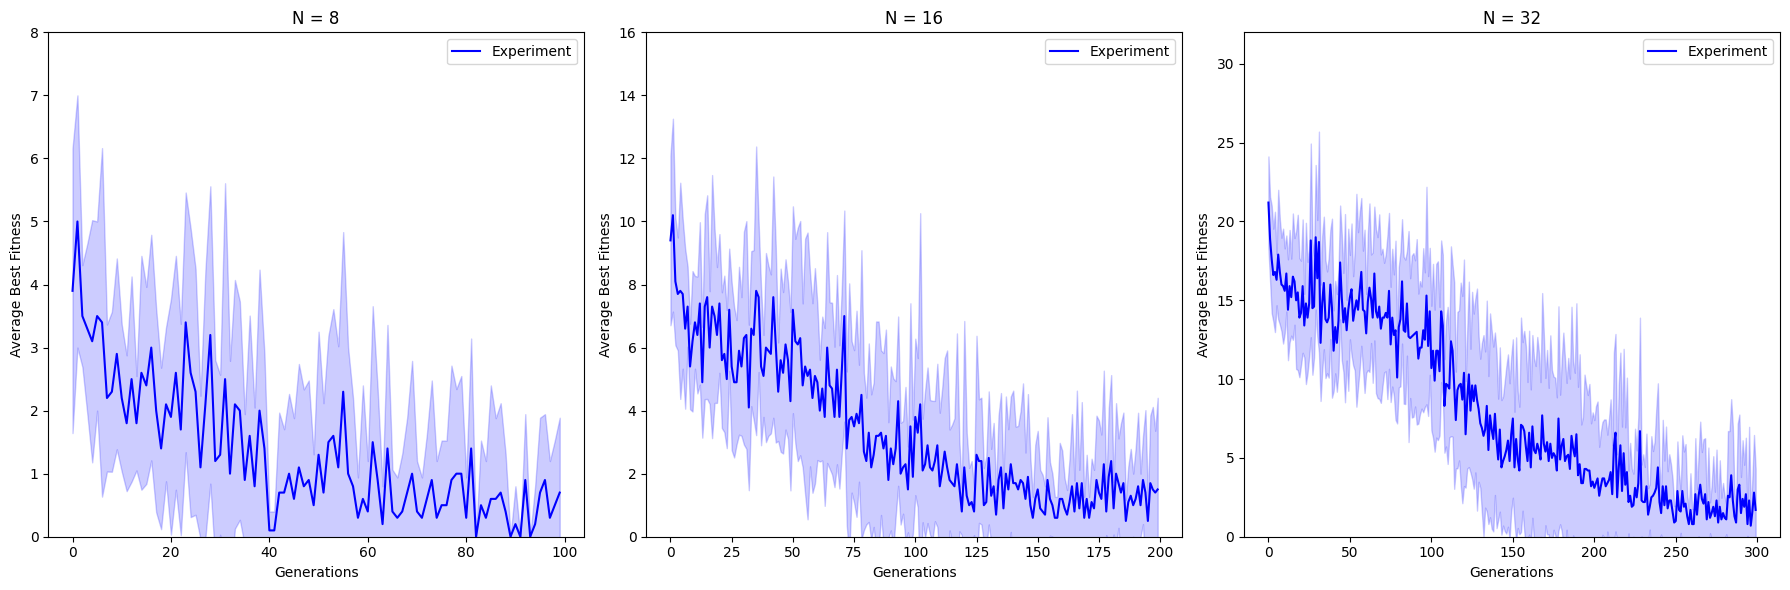

In [9]:
labels = ["N = 8", "N = 16", "N = 32"]

generate_subplot_function(
    avgs_experiment_1,
    stds_experiment_1,
    labels,
    n_columns=3,
    n_queens=[8, 16, 32],
)